<a href="https://colab.research.google.com/github/RadimKozl/Neural-network-research/blob/main/LSTM_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font style="color:black">Development of new version of LSTM function of PyTorch</font>**

## **<font style="color:blue">Introduction and theory</font>**

<p>
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to address the vanishing gradient problem, which can make it difficult for standard RNNs to learn long-term dependencies. LSTMs have a more complex architecture than standard RNNs, with additional components that allow them to selectively remember or forget information over time.
<p>

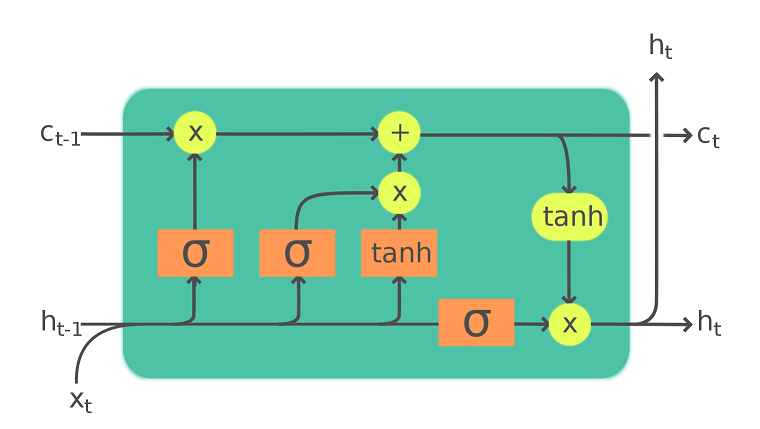

[resource of image](https://www.quantconnect.com/docs/v2/research-environment/applying-research/long-short-term-memory)

### **<font style="color:brown">Key Components of LSTM</font>**

1. ***Cell State (C_t):*** This is the horizontal line that runs straight through the entire chain, carrying information along the sequence.

2. ***Hidden State (h_t):*** This is the output of the LSTM unit, which is also passed to the next LSTM unit in the sequence.

3. ***Gates:*** LSTMs have three types of gates that control the flow of information:

- ***Forget Gate (f_t):*** Decides what information to throw away from the cell state.
- ***Input Gate (i_t):*** Decides what new information to store in the cell state.
- ***Output Gate (o_t):*** Decides what the next hidden state should be.
<br />

### **<font style="color:brown">Mathematical Formulation</font>**

The LSTM updates can be described by the following equations:

1. **Forget Gate:**

$$f_t​=\sigma(Wf​⋅[h_{t−1}​,x_t​]+b_f​)$$

2. **Input Gate:**

$$i_t​=\sigma(W_i​⋅[h_{t−1}​,x_t​]+b_i​)$$

3. **Candidate Cell State:**

$$\widetilde{C}_t​=tanh(W_C​⋅[h_{t−1​},x_t​]+b_C​)$$

4. **Update Cell State:**

$$C_t​=f_t \odot C_{t−1} ​+ i_t \odot \widetilde{C}_t​$$

5. **Output Gate:**

$$o_t​=\sigma(W_o​⋅[h_{t−1}​,x_t​]+b_o​)$$

6. **Hidden State:**

$$h_t​=o_t \odot tanh(C_t​)$$


Here, $\sigma$ is the sigmoid function, $tanh$ is the hyperbolic tangent function, $\odot$ denotes element-wise multiplication, and $W_f,W_i,W_C,W_o$​ are weight matrices.

## **<font style="color:blue">PyTorch Implementation</font>**

In PyTorch, you can use the **nn.LSTM** module to create an *LSTM* layer. Here's a simple example of how to use it:

In [3]:
import torch
import torch.nn as nn

# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Dummy input: (batch_size, seq_length, input_size)
dummy_input = torch.randn(5, 3, input_size)
output = model(dummy_input)
print(output)


tensor([[-0.2356],
        [-0.2237],
        [-0.2269],
        [-0.2396],
        [-0.2283]], grad_fn=<AddmmBackward0>)


## **<font style="color:blue">Implementing an LSTM from scratch in *PyTorch*</font>**

In [4]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights for input, forget, cell, and output gates
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        self.W_f = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        self.W_c = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        self.W_o = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        # Initialize weights and biases
        for weight in [self.W_i, self.W_f, self.W_c, self.W_o]:
            nn.init.xavier_uniform_(weight)
        for bias in [self.b_i, self.b_f, self.b_c, self.b_o]:
            nn.init.zeros_(bias)

    def forward(self, x, h_prev, c_prev):
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)

        # Compute gates
        i_t = torch.sigmoid(torch.mm(combined, self.W_i.t()) + self.b_i)
        f_t = torch.sigmoid(torch.mm(combined, self.W_f.t()) + self.b_f)
        c_tilde = torch.tanh(torch.mm(combined, self.W_c.t()) + self.b_c)
        o_t = torch.sigmoid(torch.mm(combined, self.W_o.t()) + self.b_o)

        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde

        # Compute new hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# Example usage
input_size = 10
hidden_size = 20

lstm_cell = LSTMCell(input_size, hidden_size)

# Dummy input: (batch_size, input_size)
dummy_input = torch.randn(5, input_size)
h_prev = torch.zeros(5, hidden_size)
c_prev = torch.zeros(5, hidden_size)

h_t, c_t = lstm_cell(dummy_input, h_prev, c_prev)
print("Hidden State:", h_t)
print("Cell State:", c_t)

Hidden State: tensor([[ 0.0818,  0.0655,  0.0730, -0.1552, -0.0506,  0.1436, -0.0794, -0.1271,
         -0.1377,  0.1891, -0.0440,  0.1077, -0.0369, -0.2143,  0.0176,  0.0504,
          0.2470,  0.0420,  0.1242,  0.0179],
        [-0.0037,  0.1782,  0.1724, -0.1335,  0.1736, -0.0994, -0.1293, -0.2344,
          0.0226,  0.0270, -0.0425, -0.0437,  0.1893,  0.1019, -0.1462,  0.0297,
         -0.0482, -0.0330, -0.0749,  0.1939],
        [ 0.1501, -0.0131,  0.1191, -0.0494,  0.0924, -0.1927, -0.0855, -0.0808,
         -0.3492,  0.1141, -0.1948, -0.0388, -0.1209, -0.1579, -0.0082,  0.0274,
          0.1233,  0.0191,  0.0784, -0.0250],
        [-0.0171,  0.0574, -0.0934,  0.1946, -0.1445,  0.1214,  0.0716,  0.2052,
         -0.0199, -0.0917,  0.2562,  0.1174,  0.0776,  0.1244,  0.0327, -0.0324,
         -0.1305,  0.1107,  0.1420, -0.1530],
        [ 0.0471,  0.0737,  0.2514, -0.1066, -0.0612, -0.1463,  0.0150, -0.0096,
         -0.0671,  0.1526,  0.0454,  0.1726,  0.1674,  0.1200, -0.1211, -

## **<font style="color:blue">Implementing an LSTM as function from scratch in *PyTorch*</font>**

## **<font style="color:green">Definition LSTM as function</font>**

In [5]:
def lstm_cell(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh):
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])
    cell_state = forget_gate * cell_state + input_gate * cell_gate
    hidden_state = output_gate * torch.tanh(cell_state)
    return hidden_state, cell_state

### **<font style="color:green">Application lstm_cell function</font>**

In [8]:
class LSTMModelFunctional(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModelFunctional, self).__init__()
        self.hidden_size = hidden_size
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell(x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh, self.bias_ih, self.bias_hh)
            hidden_seq.append(h_t)

        # Use the hidden state of the last time step for the output
        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20

lstm_cell = LSTMCell(input_size, hidden_size)

# Dummy input: (batch_size, input_size)
dummy_input = torch.randn(5, input_size)
h_prev = torch.zeros(5, hidden_size)
c_prev = torch.zeros(5, hidden_size)

h_t, c_t = lstm_cell(dummy_input, h_prev, c_prev)
print("Hidden State:", h_t)
print("Cell State:", c_t)

Hidden State: tensor([[    nan,  0.4621,  0.0000,  0.4621,  0.4621,  0.4621,  0.0000,  0.4621,
          0.4621,  0.4621,  0.0000,     nan,  0.0000,  0.4621,  0.4621,  0.4621,
          0.0000,  0.0000,  0.0000,  0.2398],
        [    nan,  0.0000,  0.0000,  0.4621,  0.0000,  0.4621,  0.0000,  0.0000,
          0.0000,  0.4621,  0.0000,     nan,  0.0000,  0.4621,  0.4621,  0.0000,
          0.0000,  0.4621,  0.0000, -0.1606],
        [    nan,  0.4621,  0.0000,  0.0000,  0.4621,  0.4621,  0.0000,  0.4621,
          0.4621,  0.0000,  0.0000,     nan,  0.0000,  0.0000,  0.4621,  0.4621,
          0.0000, -0.4621,  0.0000, -0.2395],
        [    nan, -0.0000,  0.0000, -0.4621, -0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000,  0.0000,     nan,  0.0000, -0.4621, -0.0000, -0.0000,
          0.0000,  0.0000,  0.0000, -0.0000],
        [    nan, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000,  0.0000,     nan,  0.0000, -0.0000, -0.0000, -